In [1]:
#загрузка библиотек
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import cv2

from torch.nn.functional import cosine_similarity

In [2]:
#загружаем и преобразуем изображения, которые хотим сравнить

image_1, image_2 = Image.open('examples/pose1.JPG'), Image.open('examples/pose2.JPG')
to_tensor = transforms.ToTensor()
image_trans_1, image_trans_2 = to_tensor(image_1), to_tensor(image_2)


In [3]:
#загружаем модель KeypointRCNN_ResNet50_FPN и веса
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights #модель

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT #веса

In [4]:
#применим модель к изображениям
model = keypointrcnn_resnet50_fpn(weights=weights, progress=False) #инициализация модели с нужными весами
model = model.eval() #переключение в режим инференса

outputs_1, outputs_2 = model([image_trans_1]), model([image_trans_2]) #inference

In [5]:
#функция по отрисовке опорных точек
def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = np.array(img)
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

(-0.5, 365.5, 567.5, -0.5)

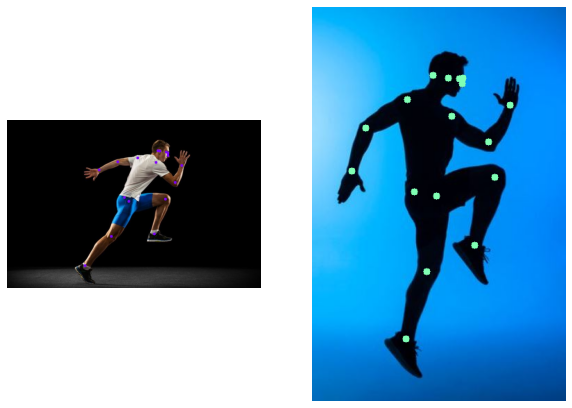

In [6]:
#отрисовка опорных точек для двух изображений
all_keypoints_1, all_scores_1, confs_1 = outputs_1[0]['keypoints'], outputs_1[0]['keypoints_scores'], outputs_1[0]['scores']
all_keypoints_2, all_scores_2, confs_2 = outputs_2[0]['keypoints'], outputs_2[0]['keypoints_scores'], outputs_2[0]['scores']

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 24))
ax[0].imshow(draw_keypoints_per_person(image_1, all_keypoints_1, all_scores_1, confs_1))
ax[1].imshow(draw_keypoints_per_person(image_2, all_keypoints_2, all_scores_2, confs_2))

ax[0].axis("off")
ax[1].axis("off")


#plt.imshow(draw_keypoints_per_person(image_1, all_keypoints, all_scores, confs))

In [7]:
#функция для получения ключевых точек и их достоверностей
def get_keypoints_per_person(
    all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):

    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            kp_list = []
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = list(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    kp_list.append(keypoint)

    return kp_list, scores

будем считать, что image_1 - эталонная поза, image_2 - рабочая поза

In [8]:
#Получим координаты опорных точек эталонной позы
model_key_points = np.array(get_keypoints_per_person(all_keypoints_1, all_scores_1, confs_1)[0])

#Получим координаты опорных точек и их достоверности для рабочей позы
train_key_points = np.array(get_keypoints_per_person(all_keypoints_2, all_scores_2, confs_2)[0])
train_confs = np.array(get_keypoints_per_person(all_keypoints_2, all_scores_2, confs_2)[1].detach().numpy())

проведем афинное преобразование. Преобразуем image2 в image1

In [9]:
# вспомогательные функции pad и Unpad
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]

# Расширим наборы ключевых точек до [[ x y 1] , [x y 1]]
Y = pad(model_key_points)
X = pad(train_key_points)

# Решим задачу наименьших квадратов X * A = Y и найдём матрицу аффинного преобразования A.
A, res, rank, s = np.linalg.lstsq(X, Y)
A[np.abs(A) < 1e-10] = 0  # превратим в "0" слишком маленькие значения

# Теперь, когда мы нашли расширенную матрицу A, мы можем преобразовать входной набор ключевых точек
transform = lambda x: unpad(np.dot(pad(x), A))
train_key_points_transform = transform(train_key_points)


C:\Users\Asus-PC\AppData\Local\Temp\ipykernel_5932\3993889263.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


# оценим косинусное сходство

In [10]:
#функция для оценки косинусного сходства
def cosine_distance(pose1, pose2):
    dist = 0
    for ind in range(len(pose1)):
      cossin = pose1[ind].dot(np.transpose(pose2[ind])) / (
          np.linalg.norm(pose1[ind]) * np.linalg.norm(pose2[ind])
      )
      #print(cossin)
      dist+=cossin
    dist = dist/len(pose1)

    return dist


Text(0.5, 1.0, 'Train\nКосинусное сходство: 0.9874')

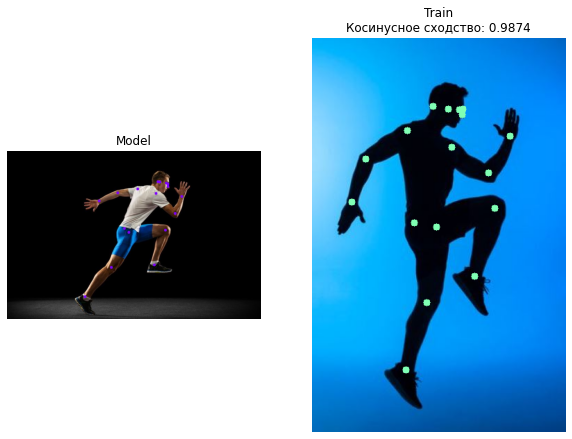

In [11]:
#оценим косинусное сходство и выведем результаты

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 24))
ax[0].imshow(draw_keypoints_per_person(image_1, all_keypoints_1, all_scores_1, confs_1))
ax[1].imshow(draw_keypoints_per_person(image_2, all_keypoints_2, all_scores_2, confs_2))

ax[0].axis("off")
ax[1].axis("off")


ax[0].set_title("Model")
ax[1].set_title("Train" + '\n'
                    + f'Косинусное сходство: {round(cosine_distance(model_key_points, train_key_points_transform),4)}')

# оценим взвешенное совпадение

In [12]:
#функция для оценки взвешенного совпадения
def weight_distance1(pose1, pose2, conf1):

    sum1 = 1 / np.sum(conf1)
    sum2 = 0

    for ind in range(len(pose1)):
        # каждый индекс i имеет x и y, у которых одинаковая оценка достоверности
        conf_ind = math.floor(conf1[ind] / 2)
        sum2 += conf1[ind] * np.linalg.norm(abs(pose1[ind] - pose2[ind]))

    weighted_dist = sum1 * sum2

    return weighted_dist

Text(0.5, 1.0, 'Train\nВзвешенное совпадение: 66.0588')

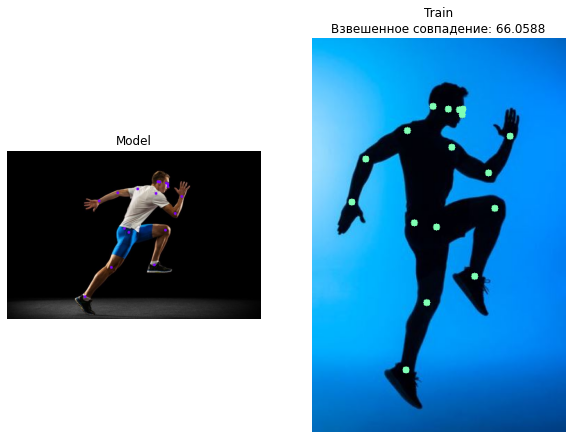

In [13]:
#оценим взвешенное совпадение и выведем результаты

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 24))
ax[0].imshow(draw_keypoints_per_person(image_1, all_keypoints_1, all_scores_1, confs_1))
ax[1].imshow(draw_keypoints_per_person(image_2, all_keypoints_2, all_scores_2, confs_2))

ax[0].axis("off")
ax[1].axis("off")


ax[0].set_title("Model")
ax[1].set_title("Train" + '\n'
                    + f'Взвешенное совпадение: {round(weight_distance1(train_key_points_transform, model_key_points, train_confs),4)}')


